In [1]:
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math
import time
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
import warnings


In [2]:
csv = pd.read_csv('Patient_1_train.csv')

#csv = pd.read_csv('Patient_2.csv')

#Shuffle panda dataframe
csv = csv.sample(frac = 1)
csv = csv.tail(500) 


# Ignore warnings
warnings.filterwarnings("ignore")

# Load the extracted features
csv = shuffle(csv)
csv = csv.reset_index(drop=True)
features = np.array(csv.drop(csv.iloc[:, [-1]], axis=1))  # Discard the class
labels = np.array(csv.iloc[:, [-1]])
feature_names = csv.columns[:-1]
print("One-second eeg segments: {}".format(features.shape[0]))
print("Extracted features: {}".format(features.shape[1]))

# Feature Selection
est = LinearSVC(penalty="l1", dual=False)
c_grid = {'C': np.logspace(-3, 1, num=30)}
clf = GridSearchCV(estimator=est, param_grid=c_grid).fit(features,labels)
reg_param = clf.best_params_['C']

lsvc = LinearSVC(C=reg_param, penalty="l1", dual=False).fit(features, labels)
model = SelectFromModel(lsvc, prefit=True)
features_reduced = model.transform(features)

# Labels (values to predict... ictal or interictal)
# Label 0 is interictal (nonseizure) and 1 is ictal (seizure)


train_features, test_features, train_labels, test_labels = train_test_split(features_reduced, labels, test_size=0.20, random_state = 42)


# (pandas) -> FOR Decision Tree Implementations

labels2 = csv["label"]
features2 = csv.drop(columns = "label", axis = 1)

# Split to train-test

train_features2, test_features2, train_labels2, test_labels2 = train_test_split(features2, labels2, test_size=0.20, random_state = 42)




One-second eeg segments: 10
Extracted features: 5372


In [3]:
# Random Forest Algorithm WITH CART -> Classification and Regression Trees 

# sckit-learn already implements CART as their tree building algorithm for decision trees into a random forest

# "scikit-learn uses an optimised version of the CART algorithm

from sklearn.ensemble import RandomForestRegressor

start = time.time()

# Instantiate 1000 decisin tree model
rf_CART = RandomForestRegressor(n_estimators = 1000, random_state = 42)

#Train model on training data
rf_CART.fit(train_features, train_labels)

end = time.time()

print(end - start, 'seconds')



3.041945219039917 seconds


In [5]:
# make predictions and calculate MSE on test set 

predict_labels_rf = rf_CART.predict(test_features)

# Calculate error
MSE_rf = np.square(np.subtract(test_labels, predict_labels_rf)).mean()
RMSE_rf = math.sqrt(MSE_rf)
print('MSE of CART Random Forest:', round(MSE_rf, 5))
print('RMSE of CART Random Forest:', round(RMSE_rf, 5))

# Calculate AUROC
AUC_rf = roc_auc_score(test_labels, predict_labels_rf)
print('AUC:', AUC_rf)

# Calculate accuracy score

accuracy_rf = accuracy_score(test_labels, np.round(abs(predict_labels_rf)), normalize=False) 
print('Accuracy:', accuracy_rf)

# Calculate confusion matrix, speficiity, sensitivity

tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(test_labels, np.round(abs(predict_labels_rf))) .ravel()
print('Confusion Matrix')
confusion_rf = confusion_matrix(test_labels, np.round(abs(predict_labels_rf)))
print(confusion_rf)
sensitivity_rf = tp_rf/(tp_rf + fn_rf)
specificity_rf = tn_rf/(tn_rf + fp_rf)
print('Sensitivity:', sensitivity_rf, 'Specificity:', specificity_rf)

# Calculate F1 Score

f1_rf = f1_score(test_labels, np.round(abs(predict_labels_rf)))
print('f1_score:', f1_rf)


MSE of CART Random Forest: 0.43944
RMSE of CART Random Forest: 0.6629
AUC: 0.9783333333333333
Accuracy: 33
Confusion Matrix
[[20  0]
 [ 2 13]]
Sensitivity: 0.8666666666666667 Specificity: 1.0
f1_score: 0.9285714285714286


In [3]:
# Decision Tree Algorithm WITH CART -> Classification and Regression Trees 

# sckit-learn already implements CART as their tree building algorithm for decision trees

from sklearn.tree import DecisionTreeClassifier

start = time.time()

dt_CART = DecisionTreeClassifier()
dt_CART.fit(train_features, train_labels)

end = time.time()

print(end - start, 'seconds')


0.018156051635742188 seconds


In [5]:
# make predictions and calculate MSE on test set

predict_labels_dt = dt_CART.predict(test_features)

# Calculate error
MSE_dt = np.square(np.subtract(test_labels, predict_labels_dt)).mean()
RMSE_dt = math.sqrt(MSE_dt)
print('MSE of CART Decision Tree:', round(MSE_dt, 5))
print('RMSE of CART Decision Tree:', round(RMSE_dt, 5))

# Calculate AUROC
AUC_dt = roc_auc_score(test_labels, predict_labels_dt)
print('AUC:', AUC_dt)

# Calculate accuracy score

accuracy_dt = accuracy_score(test_labels, np.round(abs(predict_labels_dt)), normalize=False) 
print('Accuracy:', accuracy_dt)

# Calculate confusion matrix, speficiity, sensitivity

tn_dt, fp_dt, fn_dt, tp_dt = confusion_matrix(test_labels, np.round(abs(predict_labels_dt))) .ravel()
print('Confusion Matrix')
confusion_dt = confusion_matrix(test_labels, np.round(abs(predict_labels_dt)))
print(confusion_dt)
sensitivity_dt = tp_dt/(tp_dt + fn_dt)
specificity_dt = tn_dt/(tn_dt + fp_dt)
print('Sensitivity:', sensitivity_dt, 'Specificity:', specificity_dt)

# Calculate F1 Score

f1_dt = f1_score(test_labels, np.round(abs(predict_labels_dt)))
print('f1_score:', f1_dt)

MSE of CART Decision Tree: 0.3318
RMSE of CART Decision Tree: 0.57602
AUC: 0.9698613622664256
Accuracy: 98
Confusion Matrix
[[78  1]
 [ 1 20]]
Sensitivity: 0.9523809523809523 Specificity: 0.9873417721518988
f1_score: 0.9523809523809523


In [5]:
# Decision Tree Algorithm with ID3 -> Iterative Dichotomiser 3 

# The basic algorithm used in decision trees is known as the ID3 (by Quinlan) algorithm. The ID3 algorithm builds decision trees using a top-down, greedy approach.


class ID3:
    
  def fit(self, input, output):
    data = input.copy()
    data[output.name] = output
    self.tree = self.decision_tree(data, data, input.columns, output.name)

  def predict(self, input):
    # convert input data into a dictionary of samples
    samples = input.to_dict(orient='records')
    predictions = []

    # make a prediction for every sample
    for sample in samples:
      predictions.append(self.make_prediction(sample, self.tree, 1.0))

    return predictions

  def entropy(self, attribute_column):
    # find unique values and their frequency counts for the given attribute
    values, counts = np.unique(attribute_column, return_counts=True)

    # calculate entropy for each unique value
    entropy_list = []

    for i in range(len(values)):
      probability = counts[i]/np.sum(counts)
      entropy_list.append(-probability*np.log2(probability))

    # calculate sum of individual entropy values
    total_entropy = np.sum(entropy_list)

    return total_entropy

  def information_gain(self, data, feature_attribute_name, target_attribute_name):
    # find total entropy of given subset
    total_entropy = self.entropy(data[target_attribute_name])

    # find unique values and their frequency counts for the attribute to be split
    values, counts = np.unique(data[feature_attribute_name], return_counts=True)

    # calculate weighted entropy of subset
    weighted_entropy_list = []

    for i in range(len(values)):
      subset_probability = counts[i]/np.sum(counts)
      subset_entropy = self.entropy(data.where(data[feature_attribute_name]==values[i]).dropna()[target_attribute_name])
      weighted_entropy_list.append(subset_probability*subset_entropy)

    total_weighted_entropy = np.sum(weighted_entropy_list)

    # calculate information gain
    information_gain = total_entropy - total_weighted_entropy

    return information_gain

  def decision_tree(self, data, orginal_data, feature_attribute_names, target_attribute_name, parent_node_class=None):
    # base cases:
    # if data is pure, return the majority class of subset
    unique_classes = np.unique(data[target_attribute_name])
    if len(unique_classes) <= 1:
      return unique_classes[0]
    # if subset is empty, ie. no samples, return majority class of original data
    elif len(data) == 0:
      majority_class_index = np.argmax(np.unique(original_data[target_attribute_name], return_counts=True)[1])
      return np.unique(original_data[target_attribute_name])[majority_class_index]
    # if data set contains no features to train with, return parent node class
    elif len(feature_attribute_names) == 0:
      return parent_node_class
    # if none of the above are true, construct a branch:
    else:
      # determine parent node class of current branch
      majority_class_index = np.argmax(np.unique(data[target_attribute_name], return_counts=True)[1])
      parent_node_class = unique_classes[majority_class_index]

      # determine information gain values for each feature
      # choose feature which best splits the data, ie. highest value
      ig_values = [self.information_gain(data, feature, target_attribute_name) for feature in feature_attribute_names]
      best_feature_index = np.argmax(ig_values)
      best_feature = feature_attribute_names[best_feature_index]

      # create tree structure, empty at first
      tree = {best_feature: {}}

      # remove best feature from available features, it will become the parent node
      feature_attribute_names = [i for i in feature_attribute_names if i != best_feature]

      # create nodes under parent node
      parent_attribute_values = np.unique(data[best_feature])
      for value in parent_attribute_values:
        sub_data = data.where(data[best_feature] == value).dropna()

        # call the algorithm recursively
        subtree = self.decision_tree(sub_data, orginal_data, feature_attribute_names, target_attribute_name, parent_node_class)

        # add subtree to original tree
        tree[best_feature][value] = subtree

      return tree

  def make_prediction(self, sample, tree, default=1):
    # map sample data to tree
    for attribute in list(sample.keys()):
      # check if feature exists in tree
      if attribute in list(tree.keys()):
        try:
          result = tree[attribute][sample[attribute]]
        except:
          return default

        result = tree[attribute][sample[attribute]]

        # if more attributes exist within result, recursively find best result
        if isinstance(result, dict):
          return self.make_prediction(sample, result)
        else:
          return result



In [ ]:
# Train model on training data

start = time.time()

dt_ID3 = ID3()
dt_ID3.fit(train_features2, train_labels2)

end = time.time()

print(end - start, 'seconds')


In [6]:
# Predict and calculate errors

predict_labels_dt2 = dt_ID3.predict(test_features2)

# Calculate error
MSE_dt2 = np.square(np.subtract(test_labels2, predict_labels_dt2)).mean()
RMSE_dt2 = math.sqrt(MSE_dt2)
print('MSE of ID3 Decision Tree:', round(MSE_dt2, 5))
print('RMSE of ID3 Decision Tree:', round(RMSE_dt2, 5))


# Calculate accuracy score

accuracy_dt2 = accuracy_score(test_labels2, np.round(predict_labels_dt2), normalize=False) 
print('Accuracy:', accuracy_dt2)

# Calculate confusion matrix, speficiity, sensitivity

tn_dt2, fp_dt2, fn_dt2, tp_dt2 = confusion_matrix(test_labels2, np.round(predict_labels_dt2)) .ravel()
print('Confusion Matrix')
confusion_dt2 = confusion_matrix(test_labels2, np.round(predict_labels_dt2))
print(confusion_dt2)
sensitivity_dt2 = tp_dt2/(tp_dt2 + fn_dt2) # recall
specificity_dt2 = tn_dt2/(tn_dt2 + fp_dt2) # precision
print('Sensitivity:', sensitivity_dt2, 'Specificity:', specificity_dt2)

# Calculate F1 Score

f1_dt2 = f1_score(test_labels2, np.round(predict_labels_dt2))
print('f1_score:', f1_dt2)

# Calculate precision and recall

prec_dt2 = tp_dt2/(tp_dt2 + fp

MSE of ID3 Decision Tree: 0.6
RMSE of ID3 Decision Tree: 0.7746
Accuracy: 4
Confusion Matrix
[[0 6]
 [0 4]]
Sensitivity: 1.0 Specificity: 0.0
f1_score: 0.5714285714285715


In [11]:
import sklearn
sklearn_version = sklearn.__version__

print(sklearn_version)

1.0.1


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


# plot confusion matrix (Random Forest)
x_axis_labels = ['interictal', 'ictal']
y_axis_labels = ['intereictal', 'ictal']

confusion_rf = np.transpose( np.transpose(confusion_rf)) / confusion_rf.astype(np.float).sum(axis=1)

f = sns.heatmap(confusion_rf, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# label_c_rf = flight.pivot('true label', 'predicted label') 





NameError: name 'confusion_rf' is not defined

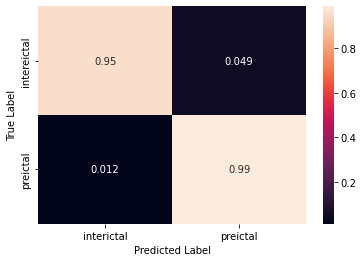

In [8]:

# plot confusion matrix (Decision Tree)

# plot confusion matrix (Random Forest)
x_axis_labels = ['interictal', 'preictal']
y_axis_labels = ['intereictal', 'preictal']


confusion_dt = np.transpose( np.transpose(confusion_dt)) / confusion_dt.astype(np.float).sum(axis=1)

f = sns.heatmap(confusion_dt, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


IndexError: index 230 is out of bounds for axis 0 with size 139

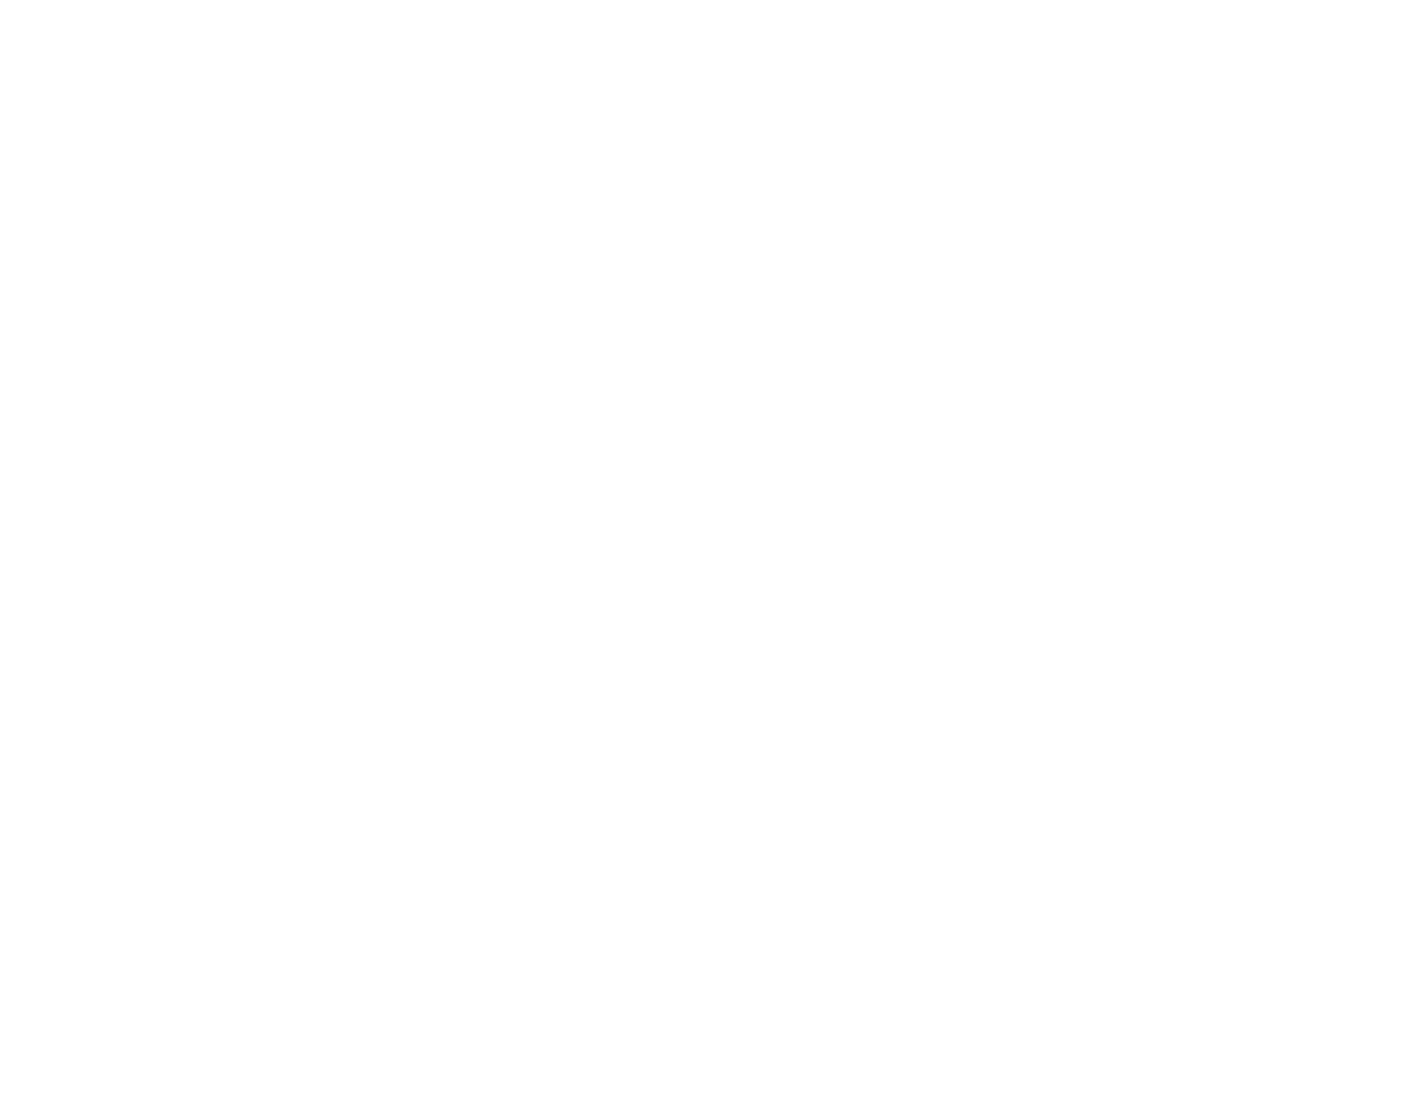

In [18]:
import matplotlib.pyplot as plt
from sklearn import tree

#Plotting decision Trees

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt_CART, 
                   feature_names=train_features,  
                   class_names=train_labels,
                   filled=True)

plt.show()